# MRI PET ECA融合

In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
import time
# import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import pickle as p
import hiddenlayer as hl
import math
from torch.utils.data.sampler import WeightedRandomSampler

if torch.cuda.is_available():
    print("cuda is available")
    torch.backends.cudnn.deterministic = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)


cuda is available
Device: cuda:0


In [2]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root,transform_mri= None,transform_pet = None):
        super(MyDataset, self).__init__()
        MRI_PET_match_all = p.load(open(root,"rb"),encoding='iso-8859-1')
        MRI = []
        PET = []
        group = []
        for index,row in MRI_PET_match_all.iterrows():
            MRI.append(row['MRI_img_array'])
            PET.append(row['PET_img_array'])
            group.append(row['Group'])
        self.MRI = MRI
        self.PET = PET
        self.group = group  
        self.transform_mri = transform_mri
        self.transform_pet = transform_pet

    def __getitem__(self, index):
        mri = torch.from_numpy(self.MRI[index].transpose(2,0,1)).float()
        pet = torch.from_numpy(self.PET[index].transpose(2,0,1)).float()
        
        
        mri = self.transform_mri(mri)
        pet = self.transform_pet(pet)
      
        
        group = self.group[index]
        
        
        
        
        return mri,pet,group

    def __len__(self):
        return len(self.MRI)
    
    def get_classes_for_all_imgs(self):
        return self.group
    

## transforms模块，进行数据预处理


# not16
train_mean_mri = [4.1620684, 4.1620684, 4.1620684]
train_std_mri = [5.2131376, 5.2131376, 5.2131376]
train_mean_pet = [4.081158, 4.081158, 4.081158] 
train_std_pet = [5.1888165, 5.1888165, 5.1888165]

test_mean_mri = [4.1623616, 4.1623616, 4.1623616]
test_std_mri = [5.2136188, 5.2136188, 5.2136188]
test_mean_pet = [4.106387, 4.106387, 4.106387]
test_std_pet = [5.18535, 5.18535, 5.18535]



#only one

# train_mean_mri = [4.240719, 4.240719, 4.240719]
# train_std_mri = [5.254782, 5.254782, 5.254782]
# train_mean_pet = [4.106597, 4.106597, 4.106597] 
# train_std_pet = [5.21822, 5.21822, 5.21822]

# test_mean_mri = [4.364004, 4.364004, 4.364004]
# test_std_mri = [5.4076633, 5.4076633, 5.4076633] 
# test_mean_pet = [4.2559123, 4.2559123, 4.2559123]
# test_std_pet = [5.373126, 5.373126, 5.373126]

# valid_mean_mri = [4.7232037, 4.7232037, 4.7232037]
# valid_std_mri =  [5.8529644, 5.8529644, 5.8529644] 
# valid_mean_pet = [4.5747848, 4.5747848, 4.5747848]
# valid_std_pet = [5.809622, 5.809622, 5.809622]

#16-in-1
# train_mean_mri = [4.176061, 4.176061, 4.176061]
# train_std_mri = [5.231413, 5.231413, 5.231413]
# train_mean_pet = [4.017313, 4.017313, 4.017313] 
# train_std_pet = [5.1714053, 5.1714053, 5.1714053]

# test_mean_mri = [4.3262687, 4.3262687, 4.3262687]
# test_std_mri = [5.419836, 5.419836, 5.419836] 
# test_mean_pet = [4.1623745, 4.1623745, 4.1623745]
# test_std_pet = [5.3586817, 5.3586817, 5.3586817]

# valid_mean_mri = [4.7232037, 4.7232037, 4.7232037]
# valid_std_mri =  [5.8529644, 5.8529644, 5.8529644] 
# valid_mean_pet = [4.5747848, 4.5747848, 4.5747848]
# valid_std_pet = [5.809622, 5.809622, 5.809622]



train_transform_mri = transforms.Compose([
    transforms.Normalize(train_mean_mri,train_std_mri),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    
])

train_transform_pet = transforms.Compose([
    transforms.Normalize(train_mean_pet,train_std_pet),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
])

test_transform_mri = transforms.Compose([
    
    transforms.Normalize(test_mean_mri,test_std_mri),
])

test_transform_pet = transforms.Compose([
   
    transforms.Normalize(test_mean_pet,test_std_pet)
])




train_data = MyDataset("/home/gc/gechang/gec_multi_fusion/end_to_end/train_not16.pkl", transform_mri =train_transform_mri,transform_pet =train_transform_pet )
test_data = MyDataset("/home/gc/gechang/gec_multi_fusion/end_to_end/test_not16.pkl", transform_mri =test_transform_mri,transform_pet =test_transform_pet)



# 数据集中，每一类的数目。
class_sample_counts = [5568,3297,2338] #not 16
#class_sample_counts = [450,237,113] #only one
weights = 1./ torch.tensor(class_sample_counts, dtype=torch.float)
# 这个 get_classes_for_all_imgs是关键
train_targets = train_data.get_classes_for_all_imgs()
samples_weights = weights[train_targets]

sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)



train_loader = DataLoader(train_data, batch_size = 32, num_workers=8, sampler = sampler,shuffle=False)
test_loader = DataLoader(test_data, batch_size = 32, num_workers=8)

In [3]:
class DuECAAttention(nn.Module):
    def __init__(self, c, b=1, gamma=2):
        super(DuECAAttention,self).__init__()
      
        t = int(abs((math.log(c, 2) + b) / gamma))
        k = t if t % 2 else t + 1 # k只能取奇数

        self.avg_pool_ch1 = nn.AdaptiveAvgPool2d(1)
        self.avg_pool_ch2 = nn.AdaptiveAvgPool2d(1)
        self.conv1_ch1 = nn.Conv1d(1, 1, kernel_size=k, padding=int(k/2), bias=False,stride=2) #inchannel = 1,outchannel=1
        self.conv1_ch2 = nn.Conv1d(1, 1, kernel_size=k, padding=int(k/2), bias=False,stride=2) #inchannel = 1,outchannel=1
        self.sigmoid_ch1 = nn.Sigmoid()
        self.sigmoid_ch2 = nn.Sigmoid()
        # self.softmax_ch1 = nn.Softmax()
        # self.softmax_ch2 = nn.Softmax()
        
        
    #定义网络的前向传播
    def forward(self,inp_ch1, inp_ch2):
        squeeze_ch1 = self.avg_pool_ch1(inp_ch1) #(n,c,h,w)->(n,c,1,1)
        # print("squeeze_ch1",squeeze_ch1.shape)
        squeeze_ch2 = self.avg_pool_ch2(inp_ch2)
        # print("squeeze_ch2",squeeze_ch2.shape)
        squeeze_comb = torch.cat((squeeze_ch1, squeeze_ch2), 1)  # [B, C*2]
        # print("squeeze_comb",squeeze_comb.shape)
        fc_ch1 = self.conv1_ch1(squeeze_comb.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        fc_ch2 = self.conv1_ch2(squeeze_comb.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        # print("fc_comb",fc_comb.shape)
        out_ch1 = self.sigmoid_ch1(fc_ch1)
        out_ch2 = self.sigmoid_ch1(fc_ch2)
        # out_ch1 = self.softmax_ch1(fc_ch1)
        # out_ch2 = self.softmax_ch2(fc_ch2)
        return out_ch1,out_ch2


In [4]:
class DuBasicBlock(nn.Module):      # 左侧的 residual block 结构（18-layer、34-layer）
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):      # 两层卷积 Conv2d + Shutcuts
        super(DuBasicBlock, self).__init__()
        
        self.conv1_ch1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.conv1_ch2 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        
        self.bn1_ch1 = nn.BatchNorm2d(planes)
        self.bn1_ch2 = nn.BatchNorm2d(planes)
        
        self.conv2_ch1 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.conv2_ch2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        
        self.bn2_ch1 = nn.BatchNorm2d(planes)
        self.bn2_ch2 = nn.BatchNorm2d(planes)

        self.channel = DuECAAttention(planes)       # Efficient Channel Attention module

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:      # Shutcuts用于构建 Conv Block 和 Identity Block
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
            

    def forward(self, c):
        c1,c2 = c.chunk(2,dim=1)
        # print("c1shape:",c1.shape)
        # print("c2shape:",c2.shape)
        
        out1 = F.relu(self.bn1_ch1(self.conv1_ch1(c1)))
        out2 = F.relu(self.bn1_ch2(self.conv1_ch2(c2)))
        
        out1 = self.bn2_ch1(self.conv2_ch1(out1))
        out2 = self.bn2_ch2(self.conv2_ch2(out2))
        
        ECA_out1,ECA_out2 = self.channel(out1,out2)
        
        out1 = out1 * ECA_out1
        out2 = out2 * ECA_out2
        
        out1 += self.shortcut(c1)
        out1 += self.shortcut(c2)
        
        out1 = F.relu(out1)
        out2 = F.relu(out2)
        
        out = torch.cat((out1,out2),dim =1)
        return out


In [5]:
class ECA_ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=3): #block有两种，BasicBlock或者Bottleneck，每个block里都有一个通道注意力
        super(ECA_ResNet, self).__init__()
        self.in_planes = 64

        self.conv1_ch1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)                  # conv1
        self.conv1_ch2 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)  
        
        self.bn1_ch1 = nn.BatchNorm2d(64)
        self.bn1_ch2 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)       # conv2_x
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)      # conv3_x
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)      # conv4_x
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)      # conv5_x
        
        self.avgpool_ch1 = nn.AdaptiveAvgPool2d((1, 1))
        self.avgpool_ch2 = nn.AdaptiveAvgPool2d((1, 1))
        
        # self.linear_ch1 = nn.Linear(512 * block.expansion, num_classes)
        # self.linear_ch2 = nn.Linear(512 * block.expansion, num_classes)
        
        self.linear =  nn.Linear(1024 * block.expansion, 3)
        
        # self.fc = nn.Linear(6, 3, bias=True)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, c1,c2):
        c1 = F.relu(self.bn1_ch1(self.conv1_ch1(c1)))
        c2 = F.relu(self.bn1_ch2(self.conv1_ch2(c2))) 
        
        # nn.Sequential()定义的网络，只能接受单输入，同时输出也只能是单输出。  
        # 解决方法，可以将两个tensor经过torch.cat组合在一起，然后在forward()中将组合拆分
        
        c = torch.cat((c1,c2),dim =1)
        
        c = self.layer1(c)
        c = self.layer2(c)
        c = self.layer3(c)
        c = self.layer4(c)
        
        c1,c2 = c.chunk(2,dim=1)
        
        c1 = self.avgpool_ch1(c1)
        c2 = self.avgpool_ch2(c2)
        
        c1 = torch.flatten(c1, 1)
        c2 = torch.flatten(c2, 1)
        
        # c1 = self.linear_ch1(c1)
        # c2 = self.linear_ch2(c2)
        
        comb = torch.cat((c1, c2), 1)
        out = self.linear(comb)
        
        return out


In [6]:
def ECA_ResNet18():
    return ECA_ResNet(DuBasicBlock, [2, 2, 2, 2])

In [7]:
class ECAfusionModel(nn.Module):
    def __init__(self):
        super(ECAfusionModel,self).__init__()
      
        self.ECA = ECA_ResNet18()
        
    #定义网络的前向传播
    def forward(self,MRI,PET):
        output = self.ECA(MRI,PET)
        return output

In [8]:
model = ECAfusionModel()
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


#记录训练过程指标
historyl = hl.History()
#使用Canves进行可视化
canvasl = hl.Canvas()

min_loss = 2

#对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(100):
    train_loss_epoch = 0
    val_loss_epoch = 0
    train_corrects = 0
    val_corrects = 0
    #对训练数据的加载器进行迭代计算
    model.train().cuda()
    for step,(mri,pet,group) in enumerate(train_loader):
        ##计算每个batch的损失
        mri = mri.to(DEVICE)
        pet = pet.to(DEVICE)
        group = group.to(DEVICE)
        output = model(mri,pet)
        loss = criterion(output,group)#交叉熵损失函数
        pre_lab = torch.argmax(output,1)
        optimizer.zero_grad()#每个迭代步的梯度初始化为0
        loss.backward()#损失的后向传播，计算梯度
        optimizer.step()#使用梯度进行优化
        train_loss_epoch += loss.item()*group.size(0)
        train_corrects += torch.sum(pre_lab == group.to(DEVICE).data)
    #计算一个epoch的损失和精度
    train_loss = train_loss_epoch/len(train_data.group)
    train_acc = train_corrects.double()/len(train_data.group)
    print("epoch:",epoch,"train_loss:",train_loss,"train_acc:",train_acc)
    
    #计算在验证集上的表现
    model.eval()
    for step,(mri,pet,group) in enumerate(test_loader):
        mri = mri.to(DEVICE)
        pet = pet.to(DEVICE)
        group = group.to(DEVICE)
        output = model(mri,pet)
        loss = criterion(output,group.to(DEVICE))
        pre_lab = torch.argmax(output,1).to(DEVICE)
        val_loss_epoch += loss.item()*group.size(0)
        val_corrects += torch.sum(pre_lab == group.to(DEVICE).data)

    #计算一个epoch上的输出loss和acc
    val_loss = val_loss_epoch/len(test_data.group)
    val_acc = val_corrects.double()/len(test_data.group)
    print("epoch:",epoch,"val_loss:",val_loss,"val_acc:",val_acc)
    
    
    if val_loss < min_loss:
        min_loss = val_loss
        print("save model")
        # 保存模型语句
        torch.save(model.state_dict(),"model_"+str(val_acc)+".pth")
    # #保存每个epoch上的输出loss和acc
    historyl.log(epoch,train_loss=train_loss,val_loss = val_loss,train_acc = train_acc.item(),val_acc = val_acc.item())
    # #可视化网络训练的过程
    # with canvasl:
    #     canvasl.draw_plot([historyl["train_loss"],historyl["val_loss"]])
    #     canvasl.draw_plot([historyl["train_acc"],historyl["val_acc"]])


epoch: 0 train_loss: 0.9228316228730338 train_acc: tensor(0.5435, device='cuda:0', dtype=torch.float64)
epoch: 0 val_loss: 1.1890404281479803 val_acc: tensor(0.3576, device='cuda:0', dtype=torch.float64)
save model
epoch: 1 train_loss: 0.521195199745042 train_acc: tensor(0.7956, device='cuda:0', dtype=torch.float64)
epoch: 1 val_loss: 1.4612564016504221 val_acc: tensor(0.3980, device='cuda:0', dtype=torch.float64)
epoch: 2 train_loss: 0.2959093302914074 train_acc: tensor(0.9107, device='cuda:0', dtype=torch.float64)
epoch: 2 val_loss: 1.3194523151982482 val_acc: tensor(0.6340, device='cuda:0', dtype=torch.float64)
epoch: 3 train_loss: 0.18141642821686607 train_acc: tensor(0.9527, device='cuda:0', dtype=torch.float64)
epoch: 3 val_loss: 0.6745115713545339 val_acc: tensor(0.7158, device='cuda:0', dtype=torch.float64)
save model
epoch: 4 train_loss: 0.1208037163636514 train_acc: tensor(0.9754, device='cuda:0', dtype=torch.float64)
epoch: 4 val_loss: 1.8930285417368238 val_acc: tensor(0.60

KeyboardInterrupt: 

In [9]:
#加载模型


model = ECAfusionModel().cuda()
 
model.load_state_dict(torch.load('/home/gc/gechang/gec_multi_fusion/pytorch/model_tensor(0.7767, device=\'cuda:0\', dtype=torch.float64).pth'))


<All keys matched successfully>

In [10]:
model

ECAfusionModel(
  (ECA): ECA_ResNet(
    (conv1_ch1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv1_ch2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1_ch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn1_ch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): DuBasicBlock(
        (conv1_ch1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv1_ch2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1_ch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn1_ch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2_ch1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2_ch2): Conv2d(64, 64, ker

In [11]:
MRI_PET= p.load(open('/home/gc/gechang/gec_multi_fusion/end_to_end/train_not16.pkl',"rb"),encoding='iso-8859-1')

In [13]:
for index,row in MRI_PET.iterrows():
    if (row["Group"] == 2):
        print(index)

400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2512
2513
2514
2515
2516

0
category id: [2]


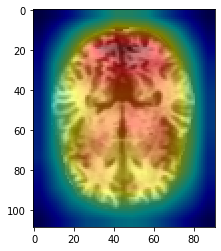

In [25]:


import matplotlib.pyplot as plt
from utils import GradCAM, show_cam_on_image
import numpy as np
target_layers = [model.ECA.layer4]


# load image


MRI_img = torch.from_numpy(MRI_PET.iloc[353]['MRI_img_array'].transpose(2,0,1)).float()
PET_img = torch.from_numpy(MRI_PET.iloc[353]['PET_img_array'].transpose(2,0,1)).float()

print(MRI_PET.iloc[353]['Group'])

# [N, C, H, W]



# expand batch dimension
input_tensor_MRI = torch.unsqueeze(MRI_img, dim=0).cuda()
input_tensor_PET = torch.unsqueeze(PET_img, dim=0).cuda()


cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
target_category = 2
grayscale_cam = cam(MRI=input_tensor_MRI, PET =input_tensor_PET)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(MRI_PET.iloc[1221]['MRI_img_array'].astype(dtype=np.float32) / 255.,
                                      grayscale_cam,
                                      use_rgb=True)

plt.imshow(visualization)
plt.show()


In [ ]:
visualization1 = show_cam_on_image(MRI_PET.iloc[985]['PET_img_array'].astype(dtype=np.float32) / 255.,
                                      grayscale_cam,
                                      use_rgb=True)

plt.imshow(visualization1)
plt.show()

In [ ]:
visualization2 = show_cam_on_image(MRI_PET.iloc[1]['PET_img_array'].astype(dtype=np.float32) / 255.,
                                      grayscale_cam,
                                      use_rgb=True)

plt.imshow(visualization2)
plt.show()


# 混淆矩阵

In [26]:
# 绘制混淆矩阵
def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix
conf_matrix = torch.zeros(3, 3)
for mri,pet,group in test_loader:
    output = model(mri.to(DEVICE),pet.to(DEVICE))
    conf_matrix = confusion_matrix(output, group, conf_matrix)

In [27]:
conf_matrix

tensor([[1561.,  262.,  229.],
        [ 129.,  589.,   31.],
        [  54.,   13.,  348.]])

: 

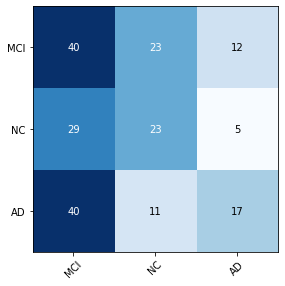

In [ ]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
Emotion_kinds=3#这个数值是具体的分类数，大家可以自行修改
labels = ['MCI', 'NC', 'AD']#每种类别的标签
 
# 显示数据
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
 
# 在图中标注数量/概率信息
thresh = conf_matrix.max() / 2  #数值颜色阈值，如果数值超过这个，就颜色加深。
for x in range(Emotion_kinds):
    for y in range(Emotion_kinds):
        # 注意这里的matrix[y, x]不是matrix[x, y]
        info = int(conf_matrix[y, x])
        plt.text(x, y, info,
                 verticalalignment='center',
                 horizontalalignment='center',
                 color="white" if info > thresh else "black")
                  
plt.tight_layout()#保证图不重叠
plt.yticks(range(Emotion_kinds), labels)
plt.xticks(range(Emotion_kinds), labels,rotation=45)#X轴字体倾斜45°
plt.show()
plt.close()